In [1]:
import os
import sys
sys.path.append(os.getcwd())
sys.path.insert(0, "../zeolite-property-prediction/code/")
sys.path.insert(0, "../zeolite-property-prediction/")


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.ticker as tick

from tqdm import tqdm


from models.equivariant_mpnn import MPNN, MPNNPORE
from utils.ZeoliteData import get_zeolite, get_data_pore, get_data_graph, get_data_megnet
from utils.dataloading import get_data, get_graph_data

#import tueplots 

from models.megnet import MEGNet
from models.cgcnn import CGCNN
from models.schnet import SchNet
from models.dimenet import DimeNetPlusPlus as DimeNet

In [2]:
import matplotlib as mpl

In [3]:
plt.rc('font', family='serif',)


In [4]:
from matplotlib import rc

In [5]:
data = get_zeolite('RHO', True)
    
ref = data['ref'] # reflections
tra = data['tra'] # translations
l = data['l'] # scale of the unit cell

# specific for MOR
atoms, hoa, X, A, d, X_pore, A_pore, d_pore, pore = get_data(l, 'RHO')

edges, idx1, idx2, idx2_oh = get_graph_data(A, d)
edges_sp, idx1_sp, idx2_sp, idx2_oh_sp = get_graph_data(A_pore, d_pore)
edges_ps, idx1_ps, idx2_ps, idx2_oh_ps = get_graph_data(A_pore.T, d_pore.T)

In [6]:
_, testloader, trainloader = get_data_pore(atoms, hoa, edges, pore, edges_sp, edges_ps, bs=32, random=True)
_, testloader2, trainloader2 = get_data_graph(atoms, hoa, edges, bs=32, random=True)
_, testloader3, trainloader3 = get_data_megnet(atoms, hoa, edges, bs=32, random=True)

In [7]:
trainX = trainloader.dataset.X.sum((1,2))[:,None].numpy()
trainy = trainloader.dataset.y[:,None].numpy()
testX = testloader.dataset.X.sum((1,2))[:,None].numpy()
testy = testloader.dataset.y[:,None].numpy()

In [8]:
from sklearn.linear_model import LinearRegression as LR

In [9]:
lr = LR()
lr.fit(trainX, trainy)

LinearRegression()

In [10]:
yhat = lr.predict(testX)

In [11]:
yhat.shape, testy.shape

((122, 1), (122, 1))

In [12]:
lr_mse, lr_mae = np.mean((testy - yhat)**2), np.mean(np.abs(testy - yhat))

In [13]:
lr_mse, lr_mae

(2.5148465284277153, 1.2432516166796264)

In [15]:
hoa.min(), hoa.max()

(17.526, 39.5594)

In [14]:
title_size=7.5
label_size=7

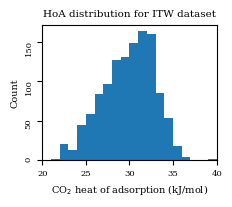

In [18]:
plt.figure(figsize=(2.25,1.75))
plt.hist(hoa, bins=np.arange(15,41,1))
plt.xlabel('CO$_2$ heat of adsorption (kJ/mol)', fontsize=label_size)
plt.ylabel('Count', fontsize=label_size)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6, rotation='vertical')
plt.title('HoA distribution for ITW dataset', fontsize=title_size)
plt.xlim(20,40)
plt.savefig('figures/datadist_rho.pdf', dpi=1200, bbox_inches="tight")
tikzz = plt.xticks()[0]

In [19]:
uniq = np.unique(atoms.sum(1))
uniq

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [20]:
hoa_x = np.tile(np.linspace(15,41,27)[:,None], (1,12))
hoa_y = np.tile(np.arange(0,12,1)[None], (hoa_x.shape[0],1))


In [21]:
hoa_x.shape

(27, 12)

In [22]:
zi = np.zeros((len(hoa_x),12))

for i in range(len(atoms)):
    
    curr_h = hoa[i]
    
    n_als = atoms[i].sum() -1
    if n_als == -1:
        n_als = 0

    for _x in range(len(hoa_x)):
        if hoa_x[_x, n_als] < curr_h <= hoa_x[_x+1, n_als]:
            zi[_x, n_als] += 1

In [23]:
sum(zi > 0)

array([2, 2, 4, 7, 6, 8, 8, 9, 8, 6, 7, 9])

In [24]:
zi = zi/zi.sum(0)[None]

In [61]:
uniq

array([ 1,  2,  3,  4,  5,  6,  8, 10, 12])

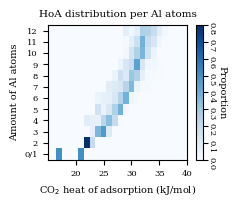

In [26]:
fig, ax = plt.subplots(figsize=(2.25,1.75))
CS = plt.pcolormesh(hoa_x, hoa_y, zi,
                  vmax=zi.max(), vmin=0, cmap='Blues')

plt.xlabel(f"CO$_2$ heat of adsorption (kJ/mol)", fontsize=label_size)
plt.ylabel(f"Amount of Al atoms", fontsize=label_size)
plt.title("HoA distribution per Al atoms", fontsize=title_size)
cbar = plt.colorbar()
plt.yticks(np.arange(0.,12,1), ['0/1',2,3,4,5,6,7,8,9,10,11,12], fontsize=6, rotation='horizontal')
plt.xticks(tikzz)
plt.xticks(fontsize=6)
plt.xlim(15,40)
plt.ylim(-0.5,11.5)
cbar.ax.tick_params(labelsize=6, rotation=270,pad=0)
cbar.ax.get_yaxis().labelpad = 8
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
cbar.set_label('Proportion', rotation=270, fontsize=label_size)
plt.savefig('figures/aldist_rho.pdf', dpi=1200, bbox_inches="tight")

In [27]:
hoa_x.shape, hoa_y.shape, zi.shape

((27, 12), (27, 12), (27, 12))

In [28]:
mpnn = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                    idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                    idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                    hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                    centers=10, mx_d=6, width=1, pool='sum', pool_pore=True).to('cuda')

In [29]:
def get_95_CI(x):
    
    ci = 1.96*np.std(x)/np.sqrt(len(x))
    return ci

In [30]:
_mae_p = []
_mse_p = []
    
for j in tqdm(range(1,11)):

    mpnn.load_state_dict(torch.load(f'model_data_random/RHO/1.0/pore/model_{j}/model.pth'))
    y_pred, y_true = mpnn.predict(testloader)

    _mse = ((y_pred - y_true)**2).mean().item()
    _mae = (y_pred - y_true).abs().mean().item()

    _mae_p.append(_mae)
    _mse_p.append(_mse)


mae_p=(np.mean(_mae_p))
mse_p=(np.mean(_mse_p))


mae_p_ci=(get_95_CI(_mae_p))
mse_p_ci=(get_95_CI(_mse_p))


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.97it/s]


In [31]:
mae_p, mse_p, mae_p_ci, mse_p_ci

(4.761098194122314, 29.122571802139284, 1.3935917828618183, 16.32408267389537)

In [32]:
best_idx = np.argmin(_mae_p)
mpnn.load_state_dict(torch.load(f'model_data_random/RHO/1.0/pore/model_{best_idx+1}/model.pth'))
y_pred, y_true = mpnn.predict(testloader)

In [33]:
from scipy.interpolate import griddata

In [34]:
y_pred.min(), y_pred.max(), y_true.min(), y_true.max()

(tensor(20.3020), tensor(32.5014), tensor(22.3559), tensor(36.6065))

In [35]:
Z = torch.ones_like(y_pred)

In [36]:
nn = 60
xmin = 20
xmax = 37
xi = np.linspace(xmin, xmax, nn)
yi = np.linspace(xmin, xmax, nn)

In [37]:
#xi.shape, yi.shape, xi, yi

In [38]:
zi = np.zeros((nn,nn))

for i in range(len(y_pred)):
    
    curr_p = y_pred[i].item()
    curr_t = y_true[i].item()
    
    for _x in range(0,nn-1):
        
        if xi[_x] < curr_p <= xi[_x+1]:
            
            for _y in range(0,nn-1):
                
                if yi[_y] < curr_t <= xi[_y+1]:
                    
                    zi[_x,_y] += 1

In [39]:
n_colors = int(zi.max())

C:\Users\20175552\AppData\Local\Temp\ipykernel_24200\4064518472.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues', n_colors+1)


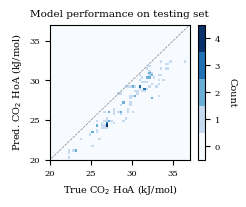

In [40]:
fig, ax = plt.subplots(figsize=(2.25,1.75))
cmap = plt.cm.get_cmap('Blues', n_colors+1)
CS = plt.pcolormesh(xi, yi, zi,
                  vmax=zi.max(), vmin=0, cmap=cmap)
plt.xlabel(f"True CO$_2$ HoA (kJ/mol)", fontsize=label_size)
plt.ylabel(f"Pred. CO$_2$ HoA (kJ/mol)", fontsize=label_size)
plt.title("Model performance on testing set", fontsize=title_size)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".5", lw=.5)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 12
cbar.set_label('Count', rotation=270, fontsize=label_size)
cbar.ax.get_yaxis().set_ticks(np.arange(n_colors/(2*(n_colors+1)), n_colors, n_colors/(n_colors+1)), np.arange(n_colors+1) )
cbar.ax.tick_params(labelsize=6)
plt.xticks(plt.yticks()[0])
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)

#plt.savefig('figures/truepred.svg', dpi=1200, bbox_inches="tight")
plt.savefig('figures/truepred_itw.pdf', dpi=1200, bbox_inches="tight")